In [1]:
# Install specific libraries
!pip install transformers
!pip install wordcloud
!pip install --upgrade scikit-learn
!pip install optuna
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 90.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.


In [2]:
# Import libraries
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, BertTokenizerFast, BertForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import optuna
from tqdm import tqdm 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

In [3]:
# Specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Set seeds for reproducibility
SEED_VALUE = 42
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_VALUE)

In [5]:
# Load Dataset
true_data = pd.read_csv('/kaggle/input/fakenewsdataset/FakeNewsDataset/True.csv')
fake_data = pd.read_csv('/kaggle/input/fakenewsdataset/FakeNewsDataset/Fake.csv')

# Combine datasets and add a label column
true_data['label'] = 0
fake_data['label'] = 1
data = pd.concat([fake_data, true_data], ignore_index=True)

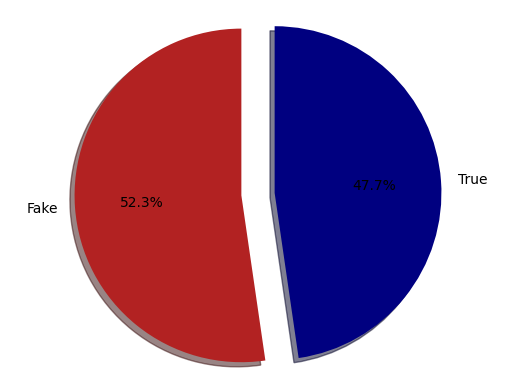

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1  
label
1    23481
0    21417
Name: count, dtype: int64


In [6]:
# Checking if our data is well balanced
label_size = [data['label'].sum(), len(data['label']) - data['label'].sum()]
plt.pie(label_size, 
         explode=[0.1, 0.1], 
         colors=['firebrick', 'navy'], 
         startangle=90, 
         shadow=True, 
         labels=['Fake', 'True'],
         autopct='%1.1f%%')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
plt.show()

# Data Exploration
print(data.head())
print(data['label'].value_counts())

In [7]:
# Train-Validation-Test set split into 70:15:15 ratio
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'], random_state=SEED_VALUE, test_size=0.3)
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=SEED_VALUE, test_size=0.5)

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1  
label
1    23481
0    21417
Name: count, dtype: int64


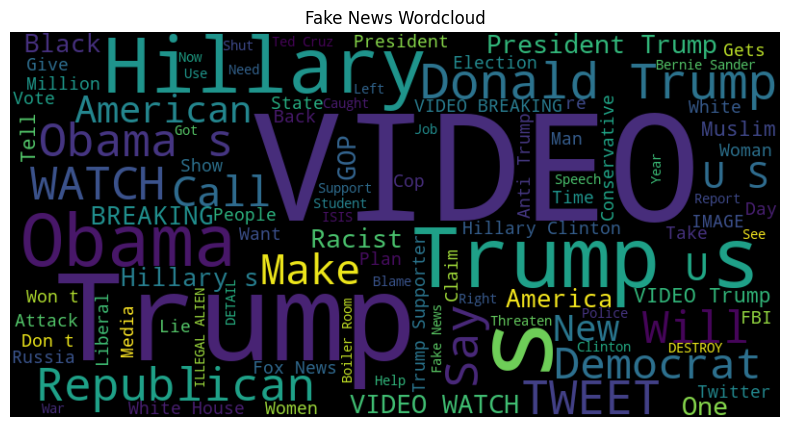

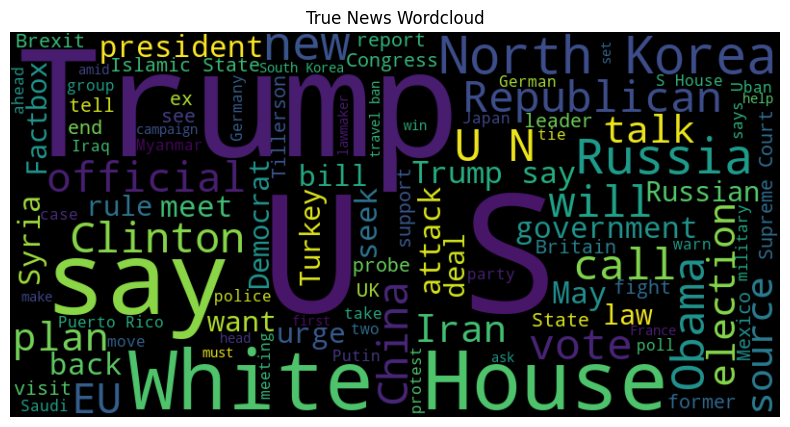

In [8]:
# Data Exploration
print(data.head())
print(data['label'].value_counts())

# Wordcloud for Fake and True News
fake_text = ' '.join(fake_data['title'])
true_text = ' '.join(true_data['title'])

fake_wordcloud = WordCloud(width=800, height=400, max_words=100).generate(fake_text)
true_wordcloud = WordCloud(width=800, height=400, max_words=100).generate(true_text)

plt.figure(figsize=(10, 5))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Wordcloud')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('True News Wordcloud')
plt.show()

Text(0, 0.5, 'Number of texts')

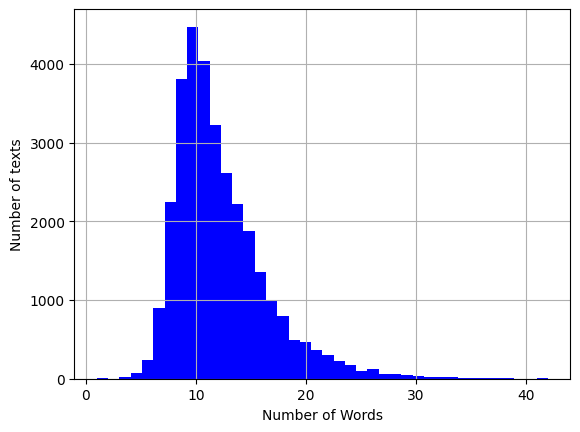

In [9]:
# Plot histogram of the number of words in train data 'text'
seq_len = [len(title.split()) for title in train_text]
pd.Series(seq_len).hist(bins = 40,color='blue')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [10]:
# Function to load tokenizer and model
def load_model_and_tokenizer(model_name):
    if model_name == 'distilbert':
        tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    elif model_name == 'distilbert-cased':
        tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)
    elif model_name == 'bert-base-cased':
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
        model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
    elif model_name == 'bert-base-uncased':
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    return tokenizer, model

In [11]:
# Max length for models (the majority of titles have word length under 40 so set the MAX_LENGTH to 64 to provide some buffer)
MAX_LENGTH = 64

In [12]:
# Tokenize and encode sequences in the train, validation, and test sets
def tokenize_data(tokenizer, texts):
    return tokenizer.batch_encode_plus(texts, max_length=MAX_LENGTH, padding='max_length', truncation=True)

In [13]:
# Convert lists to tensors for each variant
def convert_to_tensors(tokens, labels):
    return (
        torch.tensor(tokens['input_ids']),
        torch.tensor(tokens['attention_mask']),
        torch.tensor(labels.tolist())
    )

In [14]:
# Load and tokenize data for each model
model_variants = ['distilbert', 'distilbert-cased', 'bert-base-cased', 'bert-base-uncased']
tokens = {}
for variant in model_variants:
    tokenizer, model = load_model_and_tokenizer(variant)
    tokens[variant] = {
        'train': tokenize_data(tokenizer, train_text.tolist()),
        'val': tokenize_data(tokenizer, val_text.tolist()),
        'test': tokenize_data(tokenizer, test_text.tolist()),
    }

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Convert to tensors
tensor_data = {}
for variant in model_variants:
    train_seq, train_mask, train_y = convert_to_tensors(tokens[variant]['train'], train_labels)
    val_seq, val_mask, val_y = convert_to_tensors(tokens[variant]['val'], val_labels)
    test_seq, test_mask, test_y = convert_to_tensors(tokens[variant]['test'], test_labels)
    tensor_data[variant] = {
        'train': (train_seq, train_mask, train_y),
        'val': (val_seq, val_mask, val_y),
        'test': (test_seq, test_mask, test_y)
    }

In [16]:
def create_data_loader(seq, mask, labels, batch_size):
    data = TensorDataset(seq, mask, labels)
    sampler = RandomSampler(data)
    return DataLoader(data, sampler=sampler, batch_size=batch_size)

In [17]:
# Define hyperparameters for tuning
def objective(trial):
    model_name = trial.suggest_categorical('model_name', model_variants)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
    epochs = trial.suggest_int('epochs', 5, 10)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    warmup_steps = trial.suggest_int('warmup_steps', 0, 100)

    train_dataloader = create_data_loader(*tensor_data[model_name]['train'], batch_size)
    val_dataloader = create_data_loader(*tensor_data[model_name]['val'], batch_size)

    model = load_model_and_tokenizer(model_name)[1]
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    total_steps = len(train_dataloader) * epochs
    scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}/{epochs}'):
            batch = [b.to(device) for b in batch]
            sent_id, mask, labels = batch
            model.zero_grad()
            preds = model(sent_id, attention_mask=mask).logits
            loss = nn.CrossEntropyLoss()(preds, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}')

        # Validation
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f'Validation Epoch {epoch + 1}/{epochs}'):
                batch = [b.to(device) for b in batch]
                sent_id, mask, labels = batch
                preds = model(sent_id, attention_mask=mask).logits
                loss = nn.CrossEntropyLoss()(preds, labels)
                total_loss += loss.item()

        avg_val_loss = total_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}')

    return avg_val_loss  # Return average validation loss for Optuna

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED_VALUE))
study.optimize(objective, n_trials=16)

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-10-19 12:42:02,552] A new study created in memory with name: no-name-8534a18a-d88e-4849-95d3-a8f4f7e295ec
/tmp/ipykernel_23/3674895497.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
/tmp/ipykernel_23/3674895497.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAI

Epoch 1, Train Loss: 0.0452


Validation Epoch 1/9: 100%|██████████| 106/106 [00:05<00:00, 18.12it/s]


Epoch 1, Val Loss: 0.0046


Training Epoch 2/9: 100%|██████████| 492/492 [01:27<00:00,  5.62it/s]


Epoch 2, Train Loss: 0.0025


Validation Epoch 2/9: 100%|██████████| 106/106 [00:05<00:00, 18.18it/s]


Epoch 2, Val Loss: 0.0016


Training Epoch 3/9: 100%|██████████| 492/492 [01:27<00:00,  5.62it/s]


Epoch 3, Train Loss: 0.0007


Validation Epoch 3/9: 100%|██████████| 106/106 [00:05<00:00, 18.17it/s]


Epoch 3, Val Loss: 0.0026


Training Epoch 4/9: 100%|██████████| 492/492 [01:27<00:00,  5.63it/s]


Epoch 4, Train Loss: 0.0014


Validation Epoch 4/9: 100%|██████████| 106/106 [00:05<00:00, 18.17it/s]


Epoch 4, Val Loss: 0.0019


Training Epoch 5/9: 100%|██████████| 492/492 [01:27<00:00,  5.63it/s]


Epoch 5, Train Loss: 0.0003


Validation Epoch 5/9: 100%|██████████| 106/106 [00:05<00:00, 18.14it/s]


Epoch 5, Val Loss: 0.0019


Training Epoch 6/9: 100%|██████████| 492/492 [01:27<00:00,  5.62it/s]


Epoch 6, Train Loss: 0.0000


Validation Epoch 6/9: 100%|██████████| 106/106 [00:05<00:00, 18.22it/s]


Epoch 6, Val Loss: 0.0019


Training Epoch 7/9: 100%|██████████| 492/492 [01:27<00:00,  5.62it/s]


Epoch 7, Train Loss: 0.0000


Validation Epoch 7/9: 100%|██████████| 106/106 [00:05<00:00, 18.16it/s]


Epoch 7, Val Loss: 0.0020


Training Epoch 8/9: 100%|██████████| 492/492 [01:27<00:00,  5.62it/s]


Epoch 8, Train Loss: 0.0000


Validation Epoch 8/9: 100%|██████████| 106/106 [00:05<00:00, 18.16it/s]


Epoch 8, Val Loss: 0.0020


Training Epoch 9/9: 100%|██████████| 492/492 [01:27<00:00,  5.63it/s]


Epoch 9, Train Loss: 0.0000


Validation Epoch 9/9: 100%|██████████| 106/106 [00:05<00:00, 18.15it/s]
[I 2024-10-19 12:56:04,222] Trial 0 finished with value: 0.0019748336363367997 and parameters: {'model_name': 'distilbert-cased', 'batch_size': 64, 'learning_rate': 6.358358856676247e-05, 'epochs': 9, 'weight_decay': 1.1527987128232402e-06, 'warmup_steps': 97}. Best is trial 0 with value: 0.0019748336363367997.


Epoch 9, Val Loss: 0.0020


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/5: 100%|██████████| 1965/1965 [01:55<00:00, 17.00it/s]


Epoch 1, Train Loss: 0.0798


Validation Epoch 1/5: 100%|██████████| 421/421 [00:06<00:00, 61.31it/s]


Epoch 1, Val Loss: 0.0456


Training Epoch 2/5: 100%|██████████| 1965/1965 [01:55<00:00, 17.00it/s]


Epoch 2, Train Loss: 0.0233


Validation Epoch 2/5: 100%|██████████| 421/421 [00:06<00:00, 61.26it/s]


Epoch 2, Val Loss: 0.0512


Training Epoch 3/5: 100%|██████████| 1965/1965 [01:55<00:00, 17.00it/s]


Epoch 3, Train Loss: 0.0087


Validation Epoch 3/5: 100%|██████████| 421/421 [00:06<00:00, 61.15it/s]


Epoch 3, Val Loss: 0.0650


Training Epoch 4/5: 100%|██████████| 1965/1965 [01:55<00:00, 17.00it/s]


Epoch 4, Train Loss: 0.0027


Validation Epoch 4/5: 100%|██████████| 421/421 [00:06<00:00, 61.15it/s]


Epoch 4, Val Loss: 0.0849


Training Epoch 5/5: 100%|██████████| 1965/1965 [01:56<00:00, 16.90it/s]


Epoch 5, Train Loss: 0.0015


Validation Epoch 5/5: 100%|██████████| 421/421 [00:06<00:00, 61.02it/s]
[I 2024-10-19 13:06:17,713] Trial 1 finished with value: 0.07275920292043915 and parameters: {'model_name': 'distilbert', 'batch_size': 16, 'learning_rate': 6.847920095574779e-05, 'epochs': 5, 'weight_decay': 7.523742884534855e-06, 'warmup_steps': 37}. Best is trial 0 with value: 0.0019748336363367997.


Epoch 5, Val Loss: 0.0728


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/10: 100%|██████████| 983/983 [01:35<00:00, 10.26it/s]


Epoch 1, Train Loss: 0.1170


Validation Epoch 1/10: 100%|██████████| 211/211 [00:06<00:00, 35.14it/s]


Epoch 1, Val Loss: 0.0104


Training Epoch 2/10: 100%|██████████| 983/983 [01:35<00:00, 10.26it/s]


Epoch 2, Train Loss: 0.0077


Validation Epoch 2/10: 100%|██████████| 211/211 [00:06<00:00, 35.12it/s]


Epoch 2, Val Loss: 0.0063


Training Epoch 3/10: 100%|██████████| 983/983 [01:35<00:00, 10.26it/s]


Epoch 3, Train Loss: 0.0041


Validation Epoch 3/10: 100%|██████████| 211/211 [00:06<00:00, 35.13it/s]


Epoch 3, Val Loss: 0.0048


Training Epoch 4/10: 100%|██████████| 983/983 [01:35<00:00, 10.26it/s]


Epoch 4, Train Loss: 0.0029


Validation Epoch 4/10: 100%|██████████| 211/211 [00:06<00:00, 35.09it/s]


Epoch 4, Val Loss: 0.0044


Training Epoch 5/10: 100%|██████████| 983/983 [01:35<00:00, 10.25it/s]


Epoch 5, Train Loss: 0.0023


Validation Epoch 5/10: 100%|██████████| 211/211 [00:06<00:00, 35.00it/s]


Epoch 5, Val Loss: 0.0039


Training Epoch 6/10: 100%|██████████| 983/983 [01:35<00:00, 10.26it/s]


Epoch 6, Train Loss: 0.0018


Validation Epoch 6/10: 100%|██████████| 211/211 [00:06<00:00, 35.14it/s]


Epoch 6, Val Loss: 0.0037


Training Epoch 7/10: 100%|██████████| 983/983 [01:35<00:00, 10.27it/s]


Epoch 7, Train Loss: 0.0015


Validation Epoch 7/10: 100%|██████████| 211/211 [00:06<00:00, 35.15it/s]


Epoch 7, Val Loss: 0.0035


Training Epoch 8/10: 100%|██████████| 983/983 [01:35<00:00, 10.26it/s]


Epoch 8, Train Loss: 0.0011


Validation Epoch 8/10: 100%|██████████| 211/211 [00:06<00:00, 35.03it/s]


Epoch 8, Val Loss: 0.0029


Training Epoch 9/10: 100%|██████████| 983/983 [01:35<00:00, 10.26it/s]


Epoch 9, Train Loss: 0.0010


Validation Epoch 9/10: 100%|██████████| 211/211 [00:06<00:00, 35.02it/s]


Epoch 9, Val Loss: 0.0028


Training Epoch 10/10: 100%|██████████| 983/983 [01:35<00:00, 10.26it/s]


Epoch 10, Train Loss: 0.0008


Validation Epoch 10/10: 100%|██████████| 211/211 [00:05<00:00, 35.18it/s]
[I 2024-10-19 13:23:16,488] Trial 2 finished with value: 0.002759564814459305 and parameters: {'model_name': 'distilbert-cased', 'batch_size': 32, 'learning_rate': 1.5673095467235414e-06, 'epochs': 10, 'weight_decay': 0.0007886714129990489, 'warmup_steps': 81}. Best is trial 0 with value: 0.0019748336363367997.


Epoch 10, Val Loss: 0.0028


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/8: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 1, Train Loss: 0.0882


Validation Epoch 1/8: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 1, Val Loss: 0.0049


Training Epoch 2/8: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 2, Train Loss: 0.0034


Validation Epoch 2/8: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 2, Val Loss: 0.0029


Training Epoch 3/8: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 3, Train Loss: 0.0015


Validation Epoch 3/8: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 3, Val Loss: 0.0017


Training Epoch 4/8: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 4, Train Loss: 0.0006


Validation Epoch 4/8: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 4, Val Loss: 0.0020


Training Epoch 5/8: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 5, Train Loss: 0.0003


Validation Epoch 5/8: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 5, Val Loss: 0.0011


Training Epoch 6/8: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 6, Train Loss: 0.0002


Validation Epoch 6/8: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 6, Val Loss: 0.0016


Training Epoch 7/8: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 7, Train Loss: 0.0002


Validation Epoch 7/8: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 7, Val Loss: 0.0012


Training Epoch 8/8: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 8, Train Loss: 0.0001


Validation Epoch 8/8: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]
[I 2024-10-19 13:47:08,338] Trial 3 finished with value: 0.0011747540237644538 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 64, 'learning_rate': 5.975027999960295e-06, 'epochs': 8, 'weight_decay': 8.61257919259488e-06, 'warmup_steps': 52}. Best is trial 3 with value: 0.0011747540237644538.


Epoch 8, Val Loss: 0.0012


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/6: 100%|██████████| 3929/3929 [04:38<00:00, 14.11it/s]


Epoch 1, Train Loss: 0.0348


Validation Epoch 1/6: 100%|██████████| 842/842 [00:14<00:00, 59.19it/s]


Epoch 1, Val Loss: 0.0054


Training Epoch 2/6: 100%|██████████| 3929/3929 [04:38<00:00, 14.12it/s]


Epoch 2, Train Loss: 0.0027


Validation Epoch 2/6: 100%|██████████| 842/842 [00:14<00:00, 59.37it/s]


Epoch 2, Val Loss: 0.0019


Training Epoch 3/6: 100%|██████████| 3929/3929 [04:37<00:00, 14.15it/s]


Epoch 3, Train Loss: 0.0008


Validation Epoch 3/6: 100%|██████████| 842/842 [00:14<00:00, 59.32it/s]


Epoch 3, Val Loss: 0.0014


Training Epoch 4/6: 100%|██████████| 3929/3929 [04:37<00:00, 14.14it/s]


Epoch 4, Train Loss: 0.0003


Validation Epoch 4/6: 100%|██████████| 842/842 [00:14<00:00, 59.44it/s]


Epoch 4, Val Loss: 0.0012


Training Epoch 5/6: 100%|██████████| 3929/3929 [04:37<00:00, 14.18it/s]


Epoch 5, Train Loss: 0.0001


Validation Epoch 5/6: 100%|██████████| 842/842 [00:14<00:00, 58.96it/s]


Epoch 5, Val Loss: 0.0012


Training Epoch 6/6: 100%|██████████| 3929/3929 [04:37<00:00, 14.18it/s]


Epoch 6, Train Loss: 0.0001


Validation Epoch 6/6: 100%|██████████| 842/842 [00:14<00:00, 59.59it/s]
[I 2024-10-19 14:16:20,386] Trial 4 finished with value: 0.001193798063873481 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 8, 'learning_rate': 1.8427970406864558e-06, 'epochs': 6, 'weight_decay': 1.3667272915456224e-06, 'warmup_steps': 32}. Best is trial 3 with value: 0.0011747540237644538.


Epoch 6, Val Loss: 0.0012


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 1, Train Loss: 0.1996


Validation Epoch 1/10: 100%|██████████| 106/106 [00:10<00:00,  9.65it/s]


Epoch 1, Val Loss: 0.0085


Training Epoch 2/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 2, Train Loss: 0.0083


Validation Epoch 2/10: 100%|██████████| 106/106 [00:11<00:00,  9.63it/s]


Epoch 2, Val Loss: 0.0040


Training Epoch 3/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 3, Train Loss: 0.0048


Validation Epoch 3/10: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 3, Val Loss: 0.0023


Training Epoch 4/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 4, Train Loss: 0.0029


Validation Epoch 4/10: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 4, Val Loss: 0.0012


Training Epoch 5/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 5, Train Loss: 0.0028


Validation Epoch 5/10: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 5, Val Loss: 0.0014


Training Epoch 6/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 6, Train Loss: 0.0023


Validation Epoch 6/10: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 6, Val Loss: 0.0012


Training Epoch 7/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 7, Train Loss: 0.0017


Validation Epoch 7/10: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 7, Val Loss: 0.0011


Training Epoch 8/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 8, Train Loss: 0.0013


Validation Epoch 8/10: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 8, Val Loss: 0.0011


Training Epoch 9/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 9, Train Loss: 0.0012


Validation Epoch 9/10: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 9, Val Loss: 0.0011


Training Epoch 10/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 10, Train Loss: 0.0012


Validation Epoch 10/10: 100%|██████████| 106/106 [00:11<00:00,  9.63it/s]
[I 2024-10-19 14:46:09,127] Trial 5 finished with value: 0.0010396275531504972 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 64, 'learning_rate': 1.6736010167825795e-06, 'epochs': 10, 'weight_decay': 0.00020736445177905034, 'warmup_steps': 20}. Best is trial 5 with value: 0.0010396275531504972.


Epoch 10, Val Loss: 0.0010


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/8: 100%|██████████| 3929/3929 [02:31<00:00, 25.94it/s]


Epoch 1, Train Loss: 0.4557


Validation Epoch 1/8: 100%|██████████| 842/842 [00:07<00:00, 107.95it/s]


Epoch 1, Val Loss: 0.4694


Training Epoch 2/8: 100%|██████████| 3929/3929 [02:31<00:00, 25.91it/s]


Epoch 2, Train Loss: 0.6303


Validation Epoch 2/8: 100%|██████████| 842/842 [00:07<00:00, 107.94it/s]


Epoch 2, Val Loss: 0.6917


Training Epoch 3/8: 100%|██████████| 3929/3929 [02:31<00:00, 25.89it/s]


Epoch 3, Train Loss: 0.6928


Validation Epoch 3/8: 100%|██████████| 842/842 [00:07<00:00, 107.04it/s]


Epoch 3, Val Loss: 0.6925


Training Epoch 4/8: 100%|██████████| 3929/3929 [02:31<00:00, 25.85it/s]


Epoch 4, Train Loss: 0.6927


Validation Epoch 4/8: 100%|██████████| 842/842 [00:07<00:00, 107.53it/s]


Epoch 4, Val Loss: 0.6920


Training Epoch 5/8: 100%|██████████| 3929/3929 [02:32<00:00, 25.84it/s]


Epoch 5, Train Loss: 0.6923


Validation Epoch 5/8: 100%|██████████| 842/842 [00:07<00:00, 107.20it/s]


Epoch 5, Val Loss: 0.6922


Training Epoch 6/8: 100%|██████████| 3929/3929 [02:31<00:00, 25.88it/s]


Epoch 6, Train Loss: 0.6923


Validation Epoch 6/8: 100%|██████████| 842/842 [00:07<00:00, 107.92it/s]


Epoch 6, Val Loss: 0.6916


Training Epoch 7/8: 100%|██████████| 3929/3929 [02:32<00:00, 25.79it/s]


Epoch 7, Train Loss: 0.6923


Validation Epoch 7/8: 100%|██████████| 842/842 [00:07<00:00, 107.06it/s]


Epoch 7, Val Loss: 0.6917


Training Epoch 8/8: 100%|██████████| 3929/3929 [02:32<00:00, 25.84it/s]


Epoch 8, Train Loss: 0.6923


Validation Epoch 8/8: 100%|██████████| 842/842 [00:07<00:00, 107.18it/s]
[I 2024-10-19 15:07:27,381] Trial 6 finished with value: 0.6917228698730469 and parameters: {'model_name': 'distilbert-cased', 'batch_size': 8, 'learning_rate': 0.00038842777547031416, 'epochs': 8, 'weight_decay': 9.833181933644894e-06, 'warmup_steps': 6}. Best is trial 5 with value: 0.0010396275531504972.


Epoch 8, Val Loss: 0.6917


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/8: 100%|██████████| 3929/3929 [04:39<00:00, 14.06it/s]


Epoch 1, Train Loss: 0.6556


Validation Epoch 1/8: 100%|██████████| 842/842 [00:14<00:00, 58.97it/s]


Epoch 1, Val Loss: 0.6918


Training Epoch 2/8: 100%|██████████| 3929/3929 [04:39<00:00, 14.06it/s]


Epoch 2, Train Loss: 0.7062


Validation Epoch 2/8: 100%|██████████| 842/842 [00:14<00:00, 59.06it/s]


Epoch 2, Val Loss: 0.6950


Training Epoch 3/8: 100%|██████████| 3929/3929 [04:39<00:00, 14.04it/s]


Epoch 3, Train Loss: 0.7030


Validation Epoch 3/8: 100%|██████████| 842/842 [00:14<00:00, 58.76it/s]


Epoch 3, Val Loss: 0.6921


Training Epoch 4/8: 100%|██████████| 3929/3929 [04:39<00:00, 14.06it/s]


Epoch 4, Train Loss: 0.7009


Validation Epoch 4/8: 100%|██████████| 842/842 [00:14<00:00, 58.96it/s]


Epoch 4, Val Loss: 0.7002


Training Epoch 5/8: 100%|██████████| 3929/3929 [04:39<00:00, 14.07it/s]


Epoch 5, Train Loss: 0.6992


Validation Epoch 5/8: 100%|██████████| 842/842 [00:14<00:00, 59.27it/s]


Epoch 5, Val Loss: 0.6925


Training Epoch 6/8: 100%|██████████| 3929/3929 [04:39<00:00, 14.08it/s]


Epoch 6, Train Loss: 0.6979


Validation Epoch 6/8: 100%|██████████| 842/842 [00:14<00:00, 59.07it/s]


Epoch 6, Val Loss: 0.6964


Training Epoch 7/8: 100%|██████████| 3929/3929 [04:39<00:00, 14.07it/s]


Epoch 7, Train Loss: 0.6960


Validation Epoch 7/8: 100%|██████████| 842/842 [00:14<00:00, 59.04it/s]


Epoch 7, Val Loss: 0.6935


Training Epoch 8/8: 100%|██████████| 3929/3929 [04:38<00:00, 14.08it/s]


Epoch 8, Train Loss: 0.6953


Validation Epoch 8/8: 100%|██████████| 842/842 [00:14<00:00, 59.19it/s]
[I 2024-10-19 15:46:37,037] Trial 7 finished with value: 0.6916686988075103 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 8, 'learning_rate': 0.00019158219548093185, 'epochs': 8, 'weight_decay': 0.00020554245520150764, 'warmup_steps': 49}. Best is trial 5 with value: 0.0010396275531504972.


Epoch 8, Val Loss: 0.6917


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/6: 100%|██████████| 1965/1965 [01:57<00:00, 16.79it/s]


Epoch 1, Train Loss: 0.5136


Validation Epoch 1/6: 100%|██████████| 421/421 [00:06<00:00, 60.70it/s]


Epoch 1, Val Loss: 0.4937


Training Epoch 2/6: 100%|██████████| 1965/1965 [01:57<00:00, 16.79it/s]


Epoch 2, Train Loss: 0.6200


Validation Epoch 2/6: 100%|██████████| 421/421 [00:06<00:00, 60.82it/s]


Epoch 2, Val Loss: 0.6919


Training Epoch 3/6: 100%|██████████| 1965/1965 [01:57<00:00, 16.78it/s]


Epoch 3, Train Loss: 0.6926


Validation Epoch 3/6: 100%|██████████| 421/421 [00:06<00:00, 60.71it/s]


Epoch 3, Val Loss: 0.6921


Training Epoch 4/6: 100%|██████████| 1965/1965 [01:57<00:00, 16.78it/s]


Epoch 4, Train Loss: 0.6924


Validation Epoch 4/6: 100%|██████████| 421/421 [00:06<00:00, 60.68it/s]


Epoch 4, Val Loss: 0.6918


Training Epoch 5/6: 100%|██████████| 1965/1965 [01:56<00:00, 16.80it/s]


Epoch 5, Train Loss: 0.6923


Validation Epoch 5/6: 100%|██████████| 421/421 [00:06<00:00, 60.93it/s]


Epoch 5, Val Loss: 0.6918


Training Epoch 6/6: 100%|██████████| 1965/1965 [01:57<00:00, 16.78it/s]


Epoch 6, Train Loss: 0.6922


Validation Epoch 6/6: 100%|██████████| 421/421 [00:06<00:00, 60.87it/s]
[I 2024-10-19 15:59:01,437] Trial 8 finished with value: 0.6917595914310628 and parameters: {'model_name': 'distilbert', 'batch_size': 16, 'learning_rate': 0.0005280796376895364, 'epochs': 6, 'weight_decay': 1.7027416886764403e-05, 'warmup_steps': 76}. Best is trial 5 with value: 0.0010396275531504972.


Epoch 6, Val Loss: 0.6918


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/6: 100%|██████████| 3929/3929 [04:39<00:00, 14.06it/s]


Epoch 1, Train Loss: 0.1077


Validation Epoch 1/6: 100%|██████████| 842/842 [00:14<00:00, 58.81it/s]


Epoch 1, Val Loss: 0.0689


Training Epoch 2/6: 100%|██████████| 3929/3929 [04:39<00:00, 14.07it/s]


Epoch 2, Train Loss: 0.0779


Validation Epoch 2/6: 100%|██████████| 842/842 [00:14<00:00, 59.26it/s]


Epoch 2, Val Loss: 0.0633


Training Epoch 3/6: 100%|██████████| 3929/3929 [04:39<00:00, 14.08it/s]


Epoch 3, Train Loss: 0.0758


Validation Epoch 3/6: 100%|██████████| 842/842 [00:14<00:00, 59.34it/s]


Epoch 3, Val Loss: 0.0620


Training Epoch 4/6: 100%|██████████| 3929/3929 [04:39<00:00, 14.07it/s]


Epoch 4, Train Loss: 0.0768


Validation Epoch 4/6: 100%|██████████| 842/842 [00:14<00:00, 59.03it/s]


Epoch 4, Val Loss: 0.0634


Training Epoch 5/6: 100%|██████████| 3929/3929 [04:39<00:00, 14.07it/s]


Epoch 5, Train Loss: 0.0775


Validation Epoch 5/6: 100%|██████████| 842/842 [00:14<00:00, 58.89it/s]


Epoch 5, Val Loss: 0.0717


Training Epoch 6/6: 100%|██████████| 3929/3929 [04:39<00:00, 14.07it/s]


Epoch 6, Train Loss: 0.0776


Validation Epoch 6/6: 100%|██████████| 842/842 [00:14<00:00, 59.05it/s]
[I 2024-10-19 16:28:22,868] Trial 9 finished with value: 0.055705372061892335 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 8, 'learning_rate': 0.0002576417442523316, 'epochs': 6, 'weight_decay': 0.00047607677518095016, 'warmup_steps': 54}. Best is trial 5 with value: 0.0010396275531504972.


Epoch 6, Val Loss: 0.0557


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/10: 100%|██████████| 492/492 [02:48<00:00,  2.93it/s]


Epoch 1, Train Loss: 0.1216


Validation Epoch 1/10: 100%|██████████| 106/106 [00:11<00:00,  9.60it/s]


Epoch 1, Val Loss: 0.0557


Training Epoch 2/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 2, Train Loss: 0.0394


Validation Epoch 2/10: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 2, Val Loss: 0.0537


Training Epoch 3/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 3, Train Loss: 0.0205


Validation Epoch 3/10: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 3, Val Loss: 0.0455


Training Epoch 4/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 4, Train Loss: 0.0109


Validation Epoch 4/10: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 4, Val Loss: 0.0483


Training Epoch 5/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 5, Train Loss: 0.0070


Validation Epoch 5/10: 100%|██████████| 106/106 [00:11<00:00,  9.60it/s]


Epoch 5, Val Loss: 0.0566


Training Epoch 6/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 6, Train Loss: 0.0050


Validation Epoch 6/10: 100%|██████████| 106/106 [00:11<00:00,  9.63it/s]


Epoch 6, Val Loss: 0.0608


Training Epoch 7/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 7, Train Loss: 0.0044


Validation Epoch 7/10: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 7, Val Loss: 0.0623


Training Epoch 8/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 8, Train Loss: 0.0026


Validation Epoch 8/10: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 8, Val Loss: 0.0700


Training Epoch 9/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 9, Train Loss: 0.0018


Validation Epoch 9/10: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 9, Val Loss: 0.0659


Training Epoch 10/10: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 10, Train Loss: 0.0010


Validation Epoch 10/10: 100%|██████████| 106/106 [00:11<00:00,  9.63it/s]
[I 2024-10-19 16:58:12,871] Trial 10 finished with value: 0.06874703433956865 and parameters: {'model_name': 'bert-base-uncased', 'batch_size': 64, 'learning_rate': 8.792571612622856e-06, 'epochs': 10, 'weight_decay': 9.02816842234617e-05, 'warmup_steps': 3}. Best is trial 5 with value: 0.0010396275531504972.


Epoch 10, Val Loss: 0.0687


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 1, Train Loss: 0.0648


Validation Epoch 1/9: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 1, Val Loss: 0.0052


Training Epoch 2/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 2, Train Loss: 0.0042


Validation Epoch 2/9: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 2, Val Loss: 0.0018


Training Epoch 3/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 3, Train Loss: 0.0020


Validation Epoch 3/9: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 3, Val Loss: 0.0008


Training Epoch 4/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 4, Train Loss: 0.0013


Validation Epoch 4/9: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 4, Val Loss: 0.0011


Training Epoch 5/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 5, Train Loss: 0.0011


Validation Epoch 5/9: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 5, Val Loss: 0.0006


Training Epoch 6/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 6, Train Loss: 0.0005


Validation Epoch 6/9: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 6, Val Loss: 0.0007


Training Epoch 7/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 7, Train Loss: 0.0002


Validation Epoch 7/9: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 7, Val Loss: 0.0005


Training Epoch 8/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 8, Train Loss: 0.0001


Validation Epoch 8/9: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 8, Val Loss: 0.0005


Training Epoch 9/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 9, Train Loss: 0.0001


Validation Epoch 9/9: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]
[I 2024-10-19 17:25:02,671] Trial 11 finished with value: 0.0003518373082185445 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 64, 'learning_rate': 7.06298316613709e-06, 'epochs': 9, 'weight_decay': 4.4227507368684896e-05, 'warmup_steps': 23}. Best is trial 11 with value: 0.0003518373082185445.


Epoch 9, Val Loss: 0.0004


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 1, Train Loss: 0.0499


Validation Epoch 1/9: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 1, Val Loss: 0.0036


Training Epoch 2/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 2, Train Loss: 0.0025


Validation Epoch 2/9: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 2, Val Loss: 0.0011


Training Epoch 3/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 3, Train Loss: 0.0007


Validation Epoch 3/9: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 3, Val Loss: 0.0007


Training Epoch 4/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 4, Train Loss: 0.0003


Validation Epoch 4/9: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 4, Val Loss: 0.0007


Training Epoch 5/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 5, Train Loss: 0.0008


Validation Epoch 5/9: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 5, Val Loss: 0.0011


Training Epoch 6/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 6, Train Loss: 0.0002


Validation Epoch 6/9: 100%|██████████| 106/106 [00:11<00:00,  9.63it/s]


Epoch 6, Val Loss: 0.0005


Training Epoch 7/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 7, Train Loss: 0.0001


Validation Epoch 7/9: 100%|██████████| 106/106 [00:11<00:00,  9.59it/s]


Epoch 7, Val Loss: 0.0006


Training Epoch 8/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 8, Train Loss: 0.0001


Validation Epoch 8/9: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]


Epoch 8, Val Loss: 0.0007


Training Epoch 9/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 9, Train Loss: 0.0001


Validation Epoch 9/9: 100%|██████████| 106/106 [00:11<00:00,  9.61it/s]
[I 2024-10-19 17:51:52,752] Trial 12 finished with value: 0.0007090786281174965 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 64, 'learning_rate': 1.0654865730022553e-05, 'epochs': 9, 'weight_decay': 6.57317458620628e-05, 'warmup_steps': 22}. Best is trial 11 with value: 0.0003518373082185445.


Epoch 9, Val Loss: 0.0007


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 1, Train Loss: 0.1331


Validation Epoch 1/9: 100%|██████████| 106/106 [00:11<00:00,  9.62it/s]


Epoch 1, Val Loss: 0.0655


Training Epoch 2/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 2, Train Loss: 0.0413


Validation Epoch 2/9: 100%|██████████| 106/106 [00:11<00:00,  9.63it/s]


Epoch 2, Val Loss: 0.0438


Training Epoch 3/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 3, Train Loss: 0.0224


Validation Epoch 3/9: 100%|██████████| 106/106 [00:10<00:00,  9.65it/s]


Epoch 3, Val Loss: 0.0429


Training Epoch 4/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 4, Train Loss: 0.0114


Validation Epoch 4/9: 100%|██████████| 106/106 [00:11<00:00,  9.63it/s]


Epoch 4, Val Loss: 0.0434


Training Epoch 5/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 5, Train Loss: 0.0074


Validation Epoch 5/9: 100%|██████████| 106/106 [00:10<00:00,  9.65it/s]


Epoch 5, Val Loss: 0.0497


Training Epoch 6/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 6, Train Loss: 0.0055


Validation Epoch 6/9: 100%|██████████| 106/106 [00:11<00:00,  9.64it/s]


Epoch 6, Val Loss: 0.0524


Training Epoch 7/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 7, Train Loss: 0.0034


Validation Epoch 7/9: 100%|██████████| 106/106 [00:10<00:00,  9.68it/s]


Epoch 7, Val Loss: 0.0554


Training Epoch 8/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 8, Train Loss: 0.0028


Validation Epoch 8/9: 100%|██████████| 106/106 [00:10<00:00,  9.65it/s]


Epoch 8, Val Loss: 0.0582


Training Epoch 9/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 9, Train Loss: 0.0025


Validation Epoch 9/9: 100%|██████████| 106/106 [00:11<00:00,  9.63it/s]
[I 2024-10-19 18:18:42,784] Trial 13 finished with value: 0.05778043313755847 and parameters: {'model_name': 'bert-base-uncased', 'batch_size': 64, 'learning_rate': 1.2477430722845134e-05, 'epochs': 9, 'weight_decay': 4.4491336874124514e-05, 'warmup_steps': 16}. Best is trial 11 with value: 0.0003518373082185445.


Epoch 9, Val Loss: 0.0578


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/9: 100%|██████████| 983/983 [03:02<00:00,  5.38it/s]


Epoch 1, Train Loss: 0.0230


Validation Epoch 1/9: 100%|██████████| 211/211 [00:11<00:00, 19.02it/s]


Epoch 1, Val Loss: 0.0014


Training Epoch 2/9: 100%|██████████| 983/983 [03:02<00:00,  5.38it/s]


Epoch 2, Train Loss: 0.0015


Validation Epoch 2/9: 100%|██████████| 211/211 [00:11<00:00, 18.89it/s]


Epoch 2, Val Loss: 0.0016


Training Epoch 3/9: 100%|██████████| 983/983 [03:02<00:00,  5.38it/s]


Epoch 3, Train Loss: 0.0013


Validation Epoch 3/9: 100%|██████████| 211/211 [00:11<00:00, 18.91it/s]


Epoch 3, Val Loss: 0.0012


Training Epoch 4/9: 100%|██████████| 983/983 [03:02<00:00,  5.38it/s]


Epoch 4, Train Loss: 0.0002


Validation Epoch 4/9: 100%|██████████| 211/211 [00:11<00:00, 18.90it/s]


Epoch 4, Val Loss: 0.0008


Training Epoch 5/9: 100%|██████████| 983/983 [03:02<00:00,  5.37it/s]


Epoch 5, Train Loss: 0.0000


Validation Epoch 5/9: 100%|██████████| 211/211 [00:11<00:00, 18.82it/s]


Epoch 5, Val Loss: 0.0011


Training Epoch 6/9: 100%|██████████| 983/983 [03:02<00:00,  5.38it/s]


Epoch 6, Train Loss: 0.0000


Validation Epoch 6/9: 100%|██████████| 211/211 [00:11<00:00, 19.00it/s]


Epoch 6, Val Loss: 0.0012


Training Epoch 7/9: 100%|██████████| 983/983 [03:02<00:00,  5.38it/s]


Epoch 7, Train Loss: 0.0000


Validation Epoch 7/9: 100%|██████████| 211/211 [00:11<00:00, 19.01it/s]


Epoch 7, Val Loss: 0.0013


Training Epoch 8/9: 100%|██████████| 983/983 [03:02<00:00,  5.38it/s]


Epoch 8, Train Loss: 0.0000


Validation Epoch 8/9: 100%|██████████| 211/211 [00:11<00:00, 18.97it/s]


Epoch 8, Val Loss: 0.0013


Training Epoch 9/9: 100%|██████████| 983/983 [03:02<00:00,  5.39it/s]


Epoch 9, Train Loss: 0.0000


Validation Epoch 9/9: 100%|██████████| 211/211 [00:11<00:00, 19.03it/s]
[I 2024-10-19 18:47:48,288] Trial 14 finished with value: 0.0013420986591929371 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 32, 'learning_rate': 2.0145120291353763e-05, 'epochs': 9, 'weight_decay': 4.720261745970823e-05, 'warmup_steps': 27}. Best is trial 11 with value: 0.0003518373082185445.


Epoch 9, Val Loss: 0.0013


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/7: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 1, Train Loss: 0.0949


Validation Epoch 1/7: 100%|██████████| 106/106 [00:10<00:00,  9.69it/s]


Epoch 1, Val Loss: 0.0051


Training Epoch 2/7: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 2, Train Loss: 0.0038


Validation Epoch 2/7: 100%|██████████| 106/106 [00:10<00:00,  9.68it/s]


Epoch 2, Val Loss: 0.0019


Training Epoch 3/7: 100%|██████████| 492/492 [02:47<00:00,  2.94it/s]


Epoch 3, Train Loss: 0.0017


Validation Epoch 3/7: 100%|██████████| 106/106 [00:10<00:00,  9.71it/s]


Epoch 3, Val Loss: 0.0014


Training Epoch 4/7: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 4, Train Loss: 0.0010


Validation Epoch 4/7: 100%|██████████| 106/106 [00:10<00:00,  9.68it/s]


Epoch 4, Val Loss: 0.0009


Training Epoch 5/7: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 5, Train Loss: 0.0006


Validation Epoch 5/7: 100%|██████████| 106/106 [00:10<00:00,  9.67it/s]


Epoch 5, Val Loss: 0.0009


Training Epoch 6/7: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 6, Train Loss: 0.0006


Validation Epoch 6/7: 100%|██████████| 106/106 [00:10<00:00,  9.69it/s]


Epoch 6, Val Loss: 0.0009


Training Epoch 7/7: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 7, Train Loss: 0.0004


Validation Epoch 7/7: 100%|██████████| 106/106 [00:10<00:00,  9.65it/s]
[I 2024-10-19 19:08:39,613] Trial 15 finished with value: 0.0008562707165387934 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 64, 'learning_rate': 4.233229522843628e-06, 'epochs': 7, 'weight_decay': 0.00011606159532098608, 'warmup_steps': 41}. Best is trial 11 with value: 0.0003518373082185445.


Epoch 7, Val Loss: 0.0009
Number of finished trials: 16
Best trial:
  Value: 0.0003518373082185445
  Params:
    model_name: bert-base-cased
    batch_size: 64
    learning_rate: 7.06298316613709e-06
    epochs: 9
    weight_decay: 4.4227507368684896e-05
    warmup_steps: 23


In [18]:
# Use the best parameters to retrain the model
best_params = trial.params
model_name = best_params['model_name']
batch_size = best_params['batch_size']
learning_rate = best_params['learning_rate']
epochs = best_params['epochs']
weight_decay = best_params['weight_decay']
warmup_steps = best_params['warmup_steps']

# Initialize variables for tracking the best model
best_val_loss = float('inf')
best_model_state = None

train_dataloader = create_data_loader(tensor_data[model_name]['train'][0], tensor_data[model_name]['train'][1], tensor_data[model_name]['train'][2], batch_size)
val_dataloader = create_data_loader(tensor_data[model_name]['val'][0], tensor_data[model_name]['val'][1], tensor_data[model_name]['val'][2], batch_size)

model = load_model_and_tokenizer(model_name)[1]
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

total_steps = len(train_dataloader) * epochs
scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}/{epochs}'):
        batch = [b.to(device) for b in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, attention_mask=mask).logits
        loss = nn.CrossEntropyLoss()(preds, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f'Validation Epoch {epoch + 1}/{epochs}'):
            batch = [b.to(device) for b in batch]
            sent_id, mask, labels = batch
            preds = model(sent_id, attention_mask=mask).logits
            loss = nn.CrossEntropyLoss()(preds, labels)
            total_loss += loss.item()

    avg_val_loss = total_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f'Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}')
    
    # Check if the current validation loss is the best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()  # Save the model state

# After training, save the best model
torch.save(best_model_state, f'best_model_{model_name}.pth')
print(f'Best model saved with validation loss: {best_val_loss:.4f}')        
        
# Testing Phase
test_dataloader = create_data_loader(tensor_data[model_name]['test'][0], tensor_data[model_name]['test'][1], tensor_data[model_name]['test'][2], batch_size)

model.eval()
test_preds, test_labels = [], []
test_loss = 0

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Testing'):
        batch = [b.to(device) for b in batch]
        sent_id, mask, labels = batch
        preds = model(sent_id, attention_mask=mask).logits
        
        # Calculate loss
        loss = nn.CrossEntropyLoss()(preds, labels)
        test_loss += loss.item()
        
        test_preds.extend(torch.argmax(preds, dim=1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Average test loss
avg_test_loss = test_loss / len(test_dataloader)
print(f'Test Loss: {avg_test_loss:.4f}')

# Calculate test accuracy
test_accuracy = np.sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Classification Report
print(classification_report(test_labels, test_preds))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/9: 100%|██████████| 492/492 [02:48<00:00,  2.93it/s]


Epoch 1, Train Loss: 0.0622


Validation Epoch 1/9: 100%|██████████| 106/106 [00:10<00:00,  9.68it/s]


Epoch 1, Val Loss: 0.0030


Training Epoch 2/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 2, Train Loss: 0.0024


Validation Epoch 2/9: 100%|██████████| 106/106 [00:10<00:00,  9.68it/s]


Epoch 2, Val Loss: 0.0017


Training Epoch 3/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 3, Train Loss: 0.0012


Validation Epoch 3/9: 100%|██████████| 106/106 [00:10<00:00,  9.67it/s]


Epoch 3, Val Loss: 0.0003


Training Epoch 4/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 4, Train Loss: 0.0004


Validation Epoch 4/9: 100%|██████████| 106/106 [00:10<00:00,  9.67it/s]


Epoch 4, Val Loss: 0.0011


Training Epoch 5/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 5, Train Loss: 0.0005


Validation Epoch 5/9: 100%|██████████| 106/106 [00:10<00:00,  9.66it/s]


Epoch 5, Val Loss: 0.0010


Training Epoch 6/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 6, Train Loss: 0.0002


Validation Epoch 6/9: 100%|██████████| 106/106 [00:10<00:00,  9.66it/s]


Epoch 6, Val Loss: 0.0008


Training Epoch 7/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 7, Train Loss: 0.0002


Validation Epoch 7/9: 100%|██████████| 106/106 [00:10<00:00,  9.67it/s]


Epoch 7, Val Loss: 0.0007


Training Epoch 8/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 8, Train Loss: 0.0001


Validation Epoch 8/9: 100%|██████████| 106/106 [00:10<00:00,  9.67it/s]


Epoch 8, Val Loss: 0.0009


Training Epoch 9/9: 100%|██████████| 492/492 [02:47<00:00,  2.93it/s]


Epoch 9, Train Loss: 0.0001


Validation Epoch 9/9: 100%|██████████| 106/106 [00:10<00:00,  9.67it/s]


Epoch 9, Val Loss: 0.0008
Best model saved with validation loss: 0.0003


Testing: 100%|██████████| 106/106 [00:10<00:00,  9.65it/s]

Test Loss: 0.0004
Test Accuracy: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3197
           1       1.00      1.00      1.00      3538

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



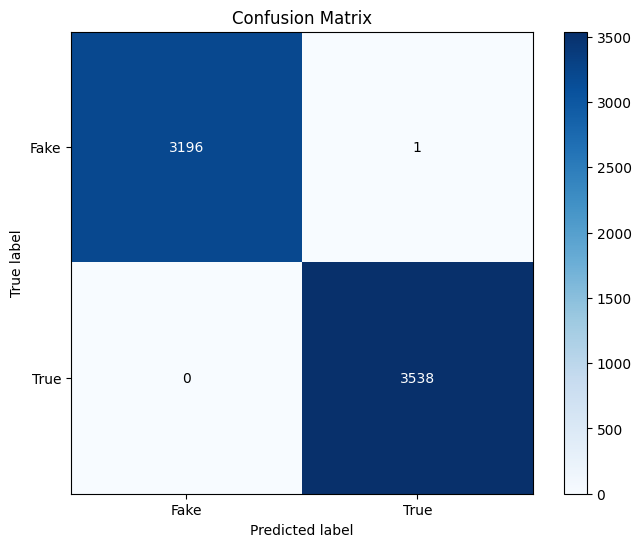

In [19]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'True'])
plt.yticks(tick_marks, ['Fake', 'True'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add text annotations
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             ha="center", va="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.show()

In [20]:
# Function to predict labels for unseen data
def predict_unseen_data(model, tokenizer, unseen_texts, max_length=MAX_LENGTH):
    model.eval()
    tokens = tokenizer.batch_encode_plus(unseen_texts, max_length=max_length, padding='max_length', truncation=True)
    
    input_ids = torch.tensor(tokens['input_ids']).to(device)
    attention_mask = torch.tensor(tokens['attention_mask']).to(device)

    with torch.no_grad():
        preds = model(input_ids, attention_mask=attention_mask).logits
        predictions = torch.argmax(preds, dim=1).cpu().numpy()
    
    return predictions

# Predictions on unseen data
unseen_data = [
    "Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",
    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",
    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",
    "Trump administration issues new rules on U.S. visa waivers"
]

# Load the best tokenizer
tokenizer = load_model_and_tokenizer(model_name)[0]

# Make predictions
predictions = predict_unseen_data(model, tokenizer, unseen_data)
print("Predictions on unseen data:", predictions)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predictions on unseen data: [1 1 0 0]
